# Exploratory Data Analysis

Performing EDA on image files is not as straightforward as when the data is tabular. After doing some research, the following aspects of the image files were analized:
* Random sampling of images
* Image size
* Class imbalance

This section is highly inspired and adapted from [this blog](https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a) about EDA for image classification.

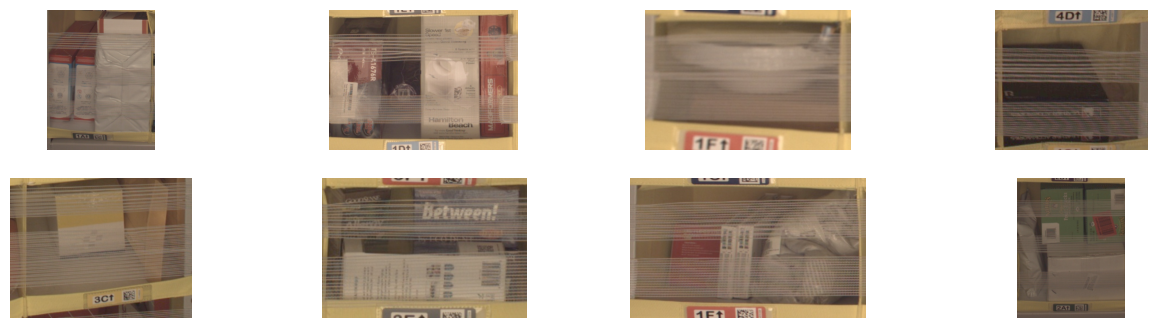

In [2]:
# Random sampling of images
from os import listdir
import matplotlib.pyplot as plt
import random

# Class to display
img_class = '4'

data_path = './train_data/'

def show_image_sample(img_class):
    '''display nxn images'''
    # Show images displayed nxn
    (nrows,ncols) = (2,4)

    imagesList = listdir(f'{data_path}/{img_class}/')
    randomImagesList = random.sample(imagesList, nrows*ncols)
    
    fig = plt.gcf()
    fig.set_size_inches(ncols*ncols, nrows*nrows)
    for i, img_file in enumerate(randomImagesList):
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        img = plt.imread(f'{data_path}/{img_class}/{img_file}')
        plt.imshow(img)
    plt.show()

show_image_sample(img_class)

**Outcome:** After reviewing several samples, it is clear that images of items mostly take the whole picture, therefore cropping would not be a good strategy and should not be taken into consideration.

In [5]:
# Plotting Image Size
import dask.bag as bag
import dask.diagnostics as diagnostics
from PIL import Image
import numpy as np
import pandas as pd
import os

directories = {
    'Class 1': 'train_data/1/',
    'Class 2': 'train_data/2/',
    'Class 3': 'train_data/3/',
    'Class 4': 'train_data/4/',
    'Class 5': 'train_data/5/'
}

def get_dims(file):
    '''Returns dimenstions for an RBG image'''
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

[########################################] | 100% Completed | 6.32 ss
[########################################] | 100% Completed | 13.93 s
[########################################] | 100% Completed | 16.86 s
[########################################] | 100% Completed | 14.51 s
[########################################] | 100% Completed | 11.89 s


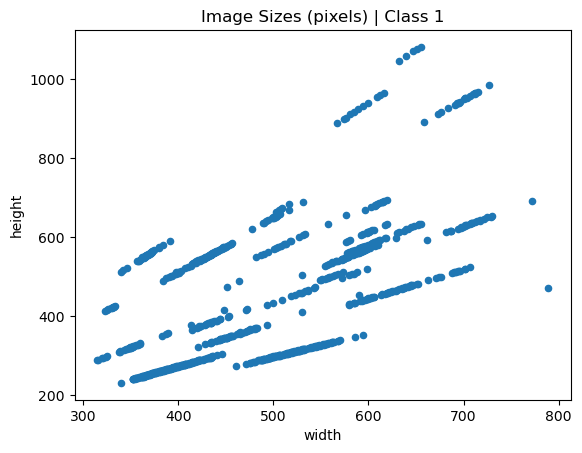

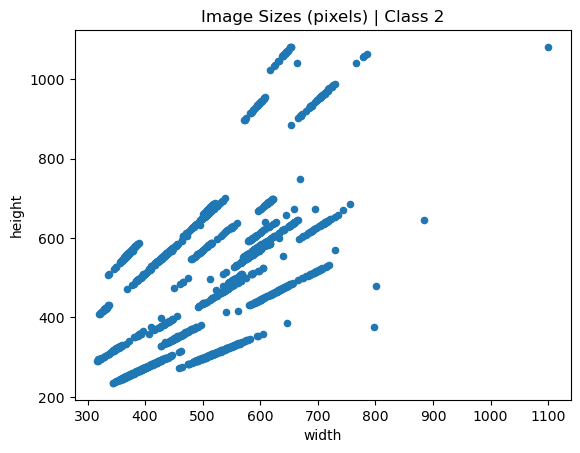

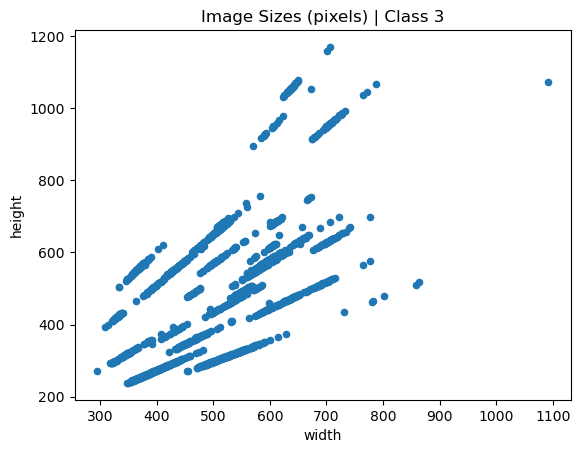

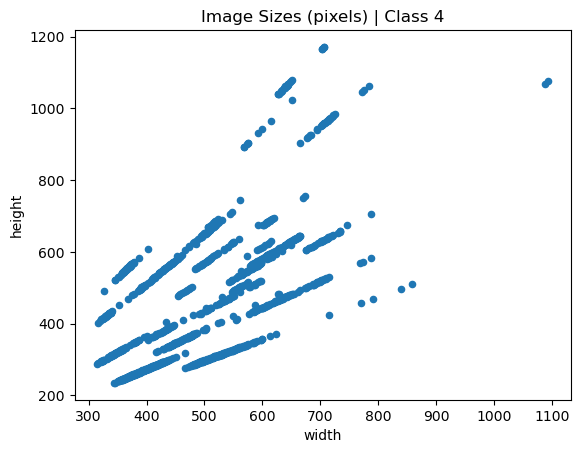

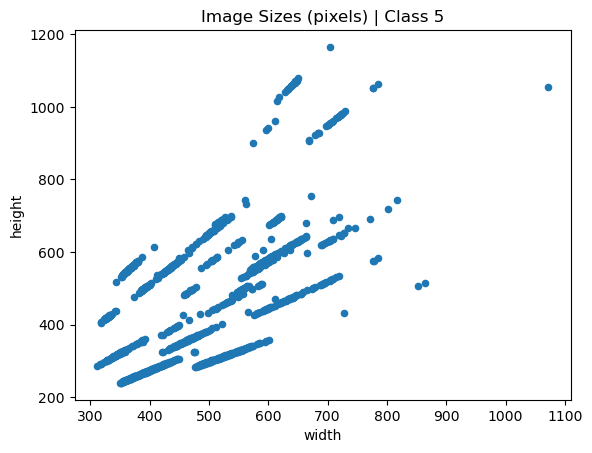

In [9]:
for n,d in directories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with diagnostics.ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.title('Image Sizes (pixels) | {}'.format(n))

**Outcome:** The images in each class have a minimum height of 200 pixels and, similarly, the minimum width is 300 for all images. Thus, for training, validation and testing purposes, resizing the images to 224 x 224 pixels sounds appropriate. This will be applied in the `transform` steps when creating data loaders for the training job.

train_data: {'Class 1': 1228, 'Class 2': 2299, 'Class 3': 2666, 'Class 4': 2373, 'Class 5': 1875}


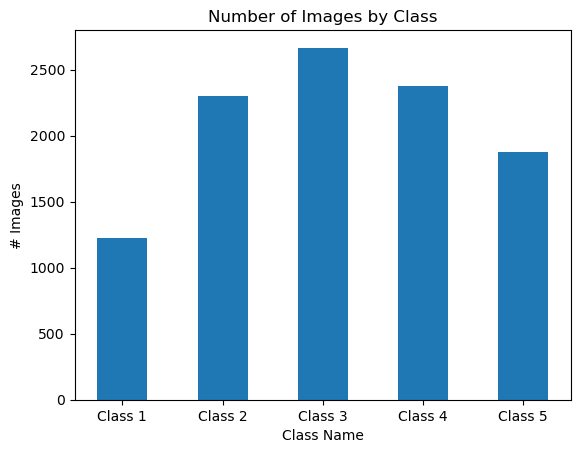

In [20]:
# Identifying Class Imbalance
from matplotlib import pyplot as plt

def get_number_img_classes(data_folder):
    img_classes = {
        'Class 1': len(os.listdir(f'{data_folder}/1')),
        'Class 2': len(os.listdir(f'{data_folder}/2')),
        'Class 3': len(os.listdir(f'{data_folder}/3')),
        'Class 4': len(os.listdir(f'{data_folder}/4')),
        'Class 5': len(os.listdir(f'{data_folder}/5'))
    }
    return img_classes

def plot_number_img_classes(data_folder):
    img_classes = get_number_img_classes(data_folder)
    plt.bar(img_classes.keys(), img_classes.values(), width = .5);
    plt.title("Number of Images by Class");
    plt.xlabel('Class Name');
    plt.ylabel('# Images');

data_folder = 'train_data'
img_classes = get_number_img_classes(data_folder)    
print(f'{data_folder}: {img_classes}') # Print number of files per class
plot_number_img_classes(data_folder)

All classes are not equally represented. There is a clear disproportion in the number of images of one class compared to another. An imbalanced dataset may bring a series of problems to machine learning, such as biased predictions, overfitting, inaccuracy. There a few techniques that can be applied to overcome this:

* Undersampling, which consists in removing samples until the classes are equally distributed.
* Oversampling, which refers to increasing the number of samples of the under-represented classes.
* Augmentation

The Class 1 and 5 are underrepresented. For simplification purposes, only the Undersampling technique will be applied to have a fixed number of 1,228 images per class (same as the Class 1). In practice, the Amazon Bin dataset is already a very large one (over 500,000 images) and more images can be included to balance the dataset in case this project needs to be scaled and more computing resources can be invested. 

For achieving a fix number of images per classes and split between train, validation and test, the [`split-folders`](https://github.com/jfilter/split-folders) library will be used in proportion 70%, 20%, 10% respectively.

In [21]:
new_total_per_class = 1227
print(f'Total images per class: {new_total_per_class} images')
new_total_train = round(new_total_per_class*0.7)
print('Training: \t\t{}*0.7={:.0f} images'.format(new_total_per_class, new_total_train))
new_total_valid = round(new_total_per_class*0.2)
print('Validation: \t\t{}*0.2={:.0f} images'.format(new_total_per_class, new_total_valid))
new_total_test = round(new_total_per_class*0.1)
print('Testing: \t\t{}*0.1={:.0f} images'.format(new_total_per_class, new_total_test))

Total images per class: 1227 images
Training: 		1227*0.7=859 images
Validation: 		1227*0.2=245 images
Testing: 		1227*0.1=123 images


In [33]:
!pip3 install split-folders
import splitfolders

# Split train/val/test with a fixed number of items
# Set 3 values, e.g. `(300, 100, 100)`, to limit the number of training values.
splitfolders.fixed("train_data", output="data_final", seed=1337, fixed=(new_total_train, new_total_valid, new_total_test))


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip



Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:01,  1.30s/ files]
Copying files: 5 files [00:01,  4.61 files/s]
...

In [34]:
# Rename validation folder
!mv data_final/val data_final/valid

In [39]:
for set in ['train', 'valid', 'test']:
    data_folder = f'data_final/{set}'
    img_classes = get_number_img_classes(data_folder)
    print(f'{data_folder}: {img_classes}')

data_final/train: {'Class 1': 859, 'Class 2': 859, 'Class 3': 859, 'Class 4': 859, 'Class 5': 859}
data_final/valid: {'Class 1': 245, 'Class 2': 245, 'Class 3': 245, 'Class 4': 245, 'Class 5': 245}
data_final/test: {'Class 1': 123, 'Class 2': 123, 'Class 3': 123, 'Class 4': 123, 'Class 5': 123}
